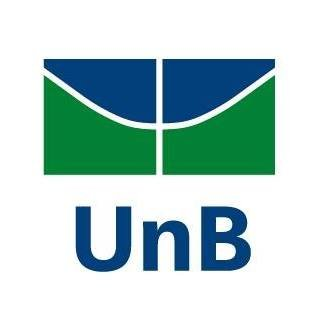

# **Exemplo Real de Data Driven em Marketing Hoteleiro**

In [1]:
# Lendo Bibliotecas
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import joblib
import shap
import matplotlib.pyplot as plt

### Dados

Os dados vem de origem do repositório do [Kaggle - Hotel Booking](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data). Essa base representa informações sobre reservas e canelamento de clientes de uma rede de hotel portuguesa.

In [2]:
# reading data
df = pd.read_csv('Dados/hotel_bookings.csv')
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


### Pré-processamento dos dados

In [3]:
# Pré-processamento dos dados
useless_col = ['days_in_waiting_list', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
               'reservation_status', 'country', 'days_in_waiting_list']
df.drop(useless_col, axis=1, inplace=True)

# Substituir NaN por zero
df.fillna(0, inplace=True)

cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_df = df[cat_cols]
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])
cat_df['year'] = cat_df['reservation_status_date'].dt.year
cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day
cat_df.drop(['reservation_status_date', 'arrival_date_month'], axis=1, inplace=True)

for col in cat_df.columns:
    cat_df = pd.get_dummies(cat_df, columns=[col], prefix=col)

num_df = df.drop(columns=cat_cols, axis=1)
num_df.drop('is_canceled', axis=1, inplace=True)

scaler = MinMaxScaler()
num_df[num_df.columns] = scaler.fit_transform(num_df)

/tmp/ipykernel_7654/2928603839.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])
/tmp/ipykernel_7654/2928603839.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['year'] = cat_df['reservation_status_date'].dt.year
/tmp/ipykernel_7654/2928603839.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

### Modelos

In [4]:
X = pd.concat([num_df, cat_df], axis=1)
y = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Salvar os dados de treino e teste
X_train.to_csv('models/X_train.csv', index=False)
X_test.to_csv('models/X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('models/y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('models/y_test.csv', index=False)

# Definir os modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'AdaBoost': AdaBoostClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'SVM': SVC(probability=True, kernel='linear', C=0.1, max_iter=1000)
}

# Treinar e salvar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report
    }
    joblib.dump(model, f'models/{name}.pkl')

# Salvar os resultados
joblib.dump(results, 'models/results.pkl')

/home/joaogabrielsouza/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/joaogabrielsouza/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/joaogabrielsouza/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


['models/results.pkl']

### SHAP

100%|===================| 95133/95512 [03:49<00:00]        

Valores SHAP calculados e salvos com sucesso.


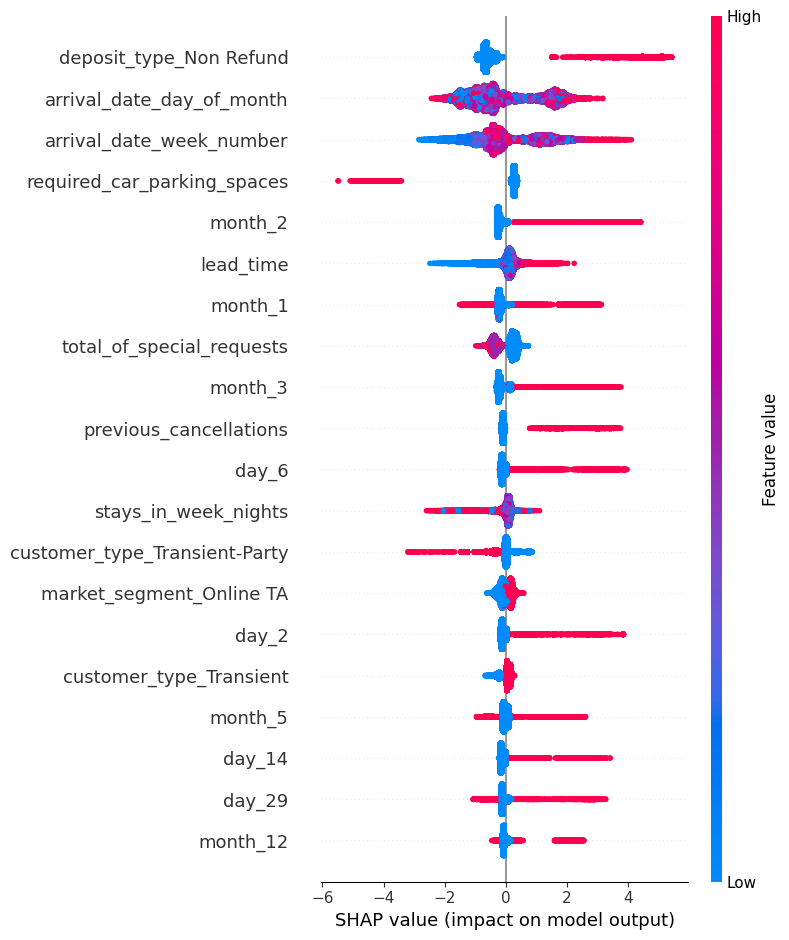

In [5]:
# Calcular e salvar os valores SHAP para o modelo XGBoost
xgb_model = models['XGBoost']
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

# Salvar valores SHAP
joblib.dump(shap_values, 'models/shap_values_xgb.pkl')
print("Valores SHAP calculados e salvos com sucesso.")

# Gerar e salvar gráficos SHAP
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig('models/shap_summary_plot.png')

<Figure size 640x480 with 0 Axes>

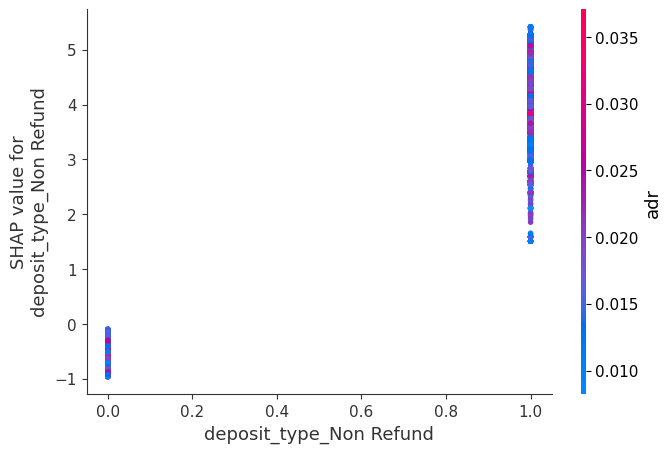

<Figure size 640x480 with 0 Axes>

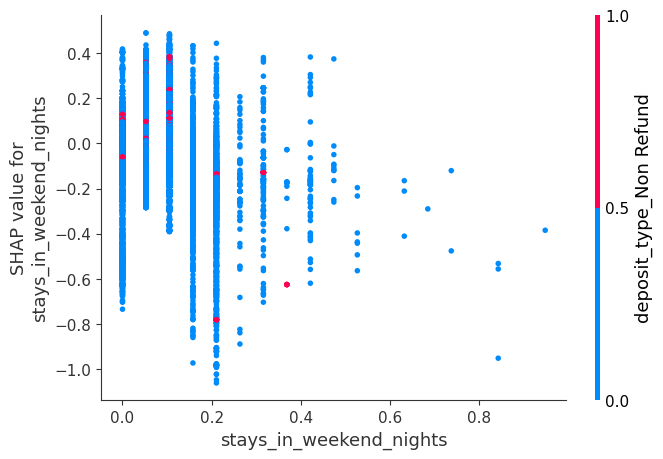

<Figure size 640x480 with 0 Axes>

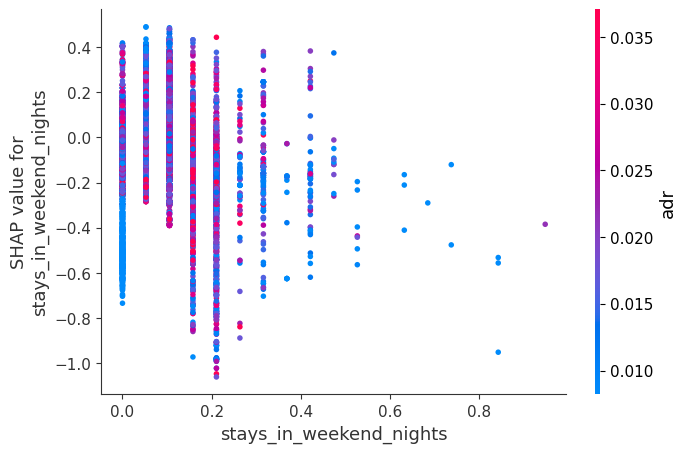

<Figure size 640x480 with 0 Axes>

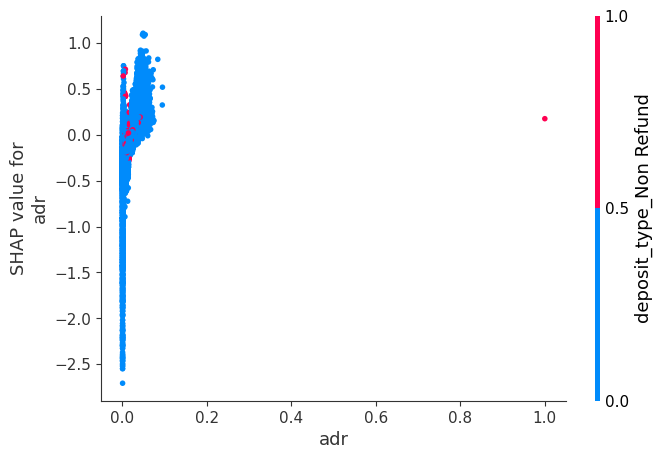

<Figure size 640x480 with 0 Axes>

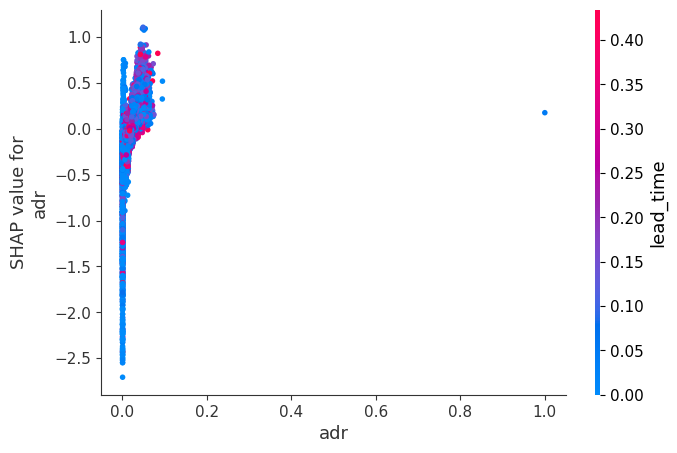

<Figure size 640x480 with 0 Axes>

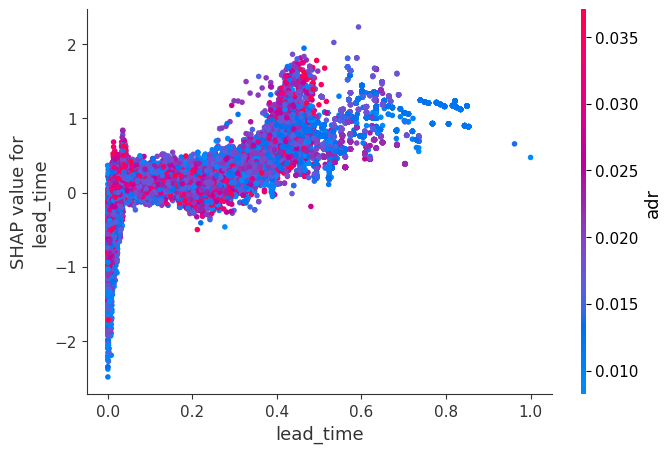

<Figure size 640x480 with 0 Axes>

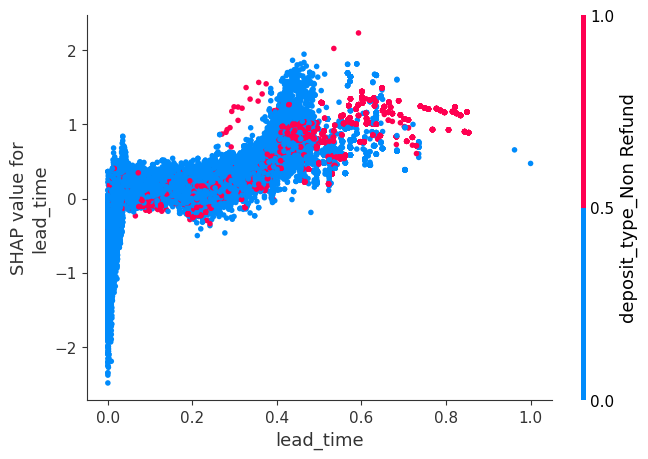

<Figure size 640x480 with 0 Axes>

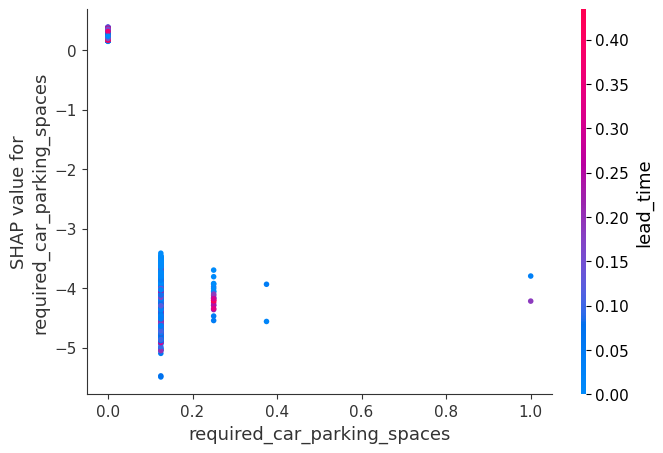

<Figure size 640x480 with 0 Axes>

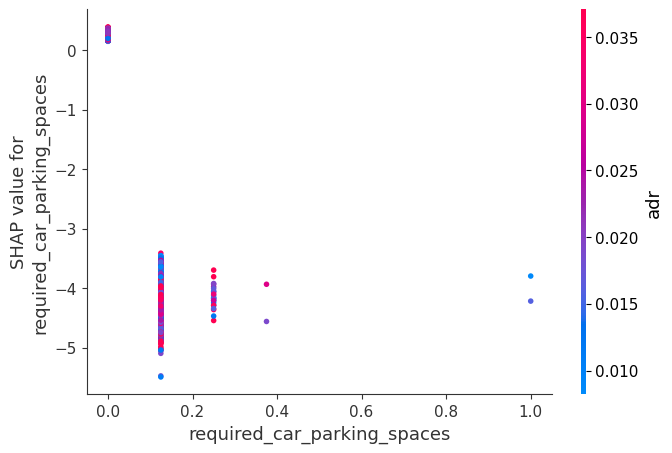

In [6]:
# Salvar gráficos de dependência SHAP específicos
def save_shap_dependence_plot(feature, shap_values, X_train, interaction_index=None, filename=None):
    plt.figure()
    shap.dependence_plot(feature, shap_values.values, X_train, interaction_index=interaction_index, show=False)
    plt.savefig(filename)

save_shap_dependence_plot('deposit_type_Non Refund', shap_values, X_train, interaction_index='adr', filename='models/shap_dependence_plot_deposit_type_Non_Refund_adr.png')
save_shap_dependence_plot('stays_in_weekend_nights', shap_values, X_train, interaction_index='deposit_type_Non Refund', filename='models/shap_dependence_plot_stays_in_weekend_nights_deposit_type_Non_Refund.png')
save_shap_dependence_plot('stays_in_weekend_nights', shap_values, X_train, interaction_index='adr', filename='models/shap_dependence_plot_stays_in_weekend_nights_adr.png')
save_shap_dependence_plot('adr', shap_values, X_train, interaction_index='deposit_type_Non Refund', filename='models/shap_dependence_plot_adr_deposit_type_Non_Refund.png')
save_shap_dependence_plot('adr', shap_values, X_train, interaction_index='lead_time', filename='models/shap_dependence_plot_adr_lead_time.png')
save_shap_dependence_plot('lead_time', shap_values, X_train, interaction_index='adr', filename='models/shap_dependence_plot_lead_time_adr.png')
save_shap_dependence_plot('lead_time', shap_values, X_train, interaction_index='deposit_type_Non Refund', filename='models/shap_dependence_plot_lead_time_deposit_type_Non_Refund.png')
save_shap_dependence_plot('required_car_parking_spaces', shap_values, X_train, interaction_index='lead_time', filename='models/shap_dependence_plot_required_car_parking_spaces_lead_time.png')
save_shap_dependence_plot('required_car_parking_spaces', shap_values, X_train, interaction_index='adr', filename='models/shap_dependence_plot_required_car_parking_spaces_adr.png')

In [7]:
# Análise local
y_pred_train = xgb_model.predict(X_train)

# Exemplo com y_pred=1
example_index_1 = np.where(y_pred_train == 1)[0][0]
shap_explanation_1 = shap.Explanation(values=shap_values.values[example_index_1],
                                      base_values=shap_values.base_values[example_index_1],
                                      data=X_train.iloc[example_index_1])

# Personalizar e salvar o gráfico Waterfall
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_explanation_1, show=False)
plt.title('Explicação Local - Exemplo com Previsão de Cancelamento (y_pred=1)')
plt.savefig('models/shap_waterfall_plot_1.png', bbox_inches='tight')
plt.close()

# Exemplo com y_pred=0
example_index_0 = np.where(y_pred_train == 0)[0][0]
shap_explanation_0 = shap.Explanation(values=shap_values.values[example_index_0],
                                      base_values=shap_values.base_values[example_index_0],
                                      data=X_train.iloc[example_index_0])

# Personalizar e salvar o gráfico Waterfall
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_explanation_0, show=False)
plt.title('Explicação Local - Exemplo sem Previsão de Cancelamento (y_pred=0)')
plt.savefig('models/shap_waterfall_plot_0.png', bbox_inches='tight')
plt.close()

print("Gráficos SHAP gerados e salvos com sucesso.")

Gráficos SHAP gerados e salvos com sucesso.
